In [1]:
import librosa
import numpy as np
import os
import pandas as pd

In [ ]:
# Feature Extraction Functions

# 1. Energy and Power
def extract_energy(speech):
    return librosa.feature.rms(y=speech)[0]  # Root mean square energy

# 2. Pitch (Fundamental Frequency) Statistics
def extract_pitch(speech, rate):
    pitch, _ = librosa.core.piptrack(y=speech, sr=rate)
    pitch = pitch[pitch > 0]  
    return pitch

# 3. Pitch Statistics
def pitch_stats(pitch):
    min_pitch = np.min(pitch)
    max_pitch = np.max(pitch)
    mean_pitch = np.mean(pitch)
    pitch_sd = np.std(pitch)
    pitch_abs = np.mean(np.abs(pitch))
    pitch_quant = np.quantile(pitch, [0.25, 0.5, 0.75])
    diff_pitch_max_min = max_pitch - min_pitch
    diff_pitch_max_mean = max_pitch - mean_pitch
    diff_pitch_max_mode = max_pitch - np.median(pitch)
    return min_pitch, max_pitch, mean_pitch, pitch_sd, pitch_abs, pitch_quant, diff_pitch_max_min, diff_pitch_max_mean, diff_pitch_max_mode

# 4. Intensity (RMS)
def intensity_features(speech):
    intensity = librosa.feature.rms(y=speech)[0]
    intensity_min = np.min(intensity)
    intensity_max = np.max(intensity)
    intensity_mean = np.mean(intensity)
    intensity_sd = np.std(intensity)
    intensity_quant = np.quantile(intensity, [0.25, 0.5, 0.75])
    diff_int_max_min = intensity_max - intensity_min
    diff_int_max_mean = intensity_max - intensity_mean
    diff_int_max_mode = intensity_max - np.median(intensity)
    return intensity_min, intensity_max, intensity_mean, intensity_sd, intensity_quant, diff_int_max_min, diff_int_max_mean, diff_int_max_mode

# 5. Jitter and Shimmer
def jitter_shimmer(speech, rate):
    # Jitter: Measure of pitch variation
    pitch, voiced_flag = librosa.core.piptrack(y=speech, sr=rate)
    jitter = np.std(pitch[pitch > 0])
    
    # Shimmer: Measure of amplitude variation (calculated based on RMS)
    intensity = librosa.feature.rms(y=speech)[0]
    shimmer = np.std(intensity)
    
    return jitter, shimmer

# 6. Speech Rate and Pauses
def speech_rate(speech, rate):
    onset_env = librosa.onset.onset_strength(y=speech, sr=rate)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=rate)
    speak_rate = len(onset_frames) / (len(speech) / rate)
    return speak_rate

def pause_features(speech, rate):
    onset_env = librosa.onset.onset_strength(y=speech, sr=rate)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=rate)
    intervals = librosa.frames_to_time(onset_frames, sr=rate)  
    pauses = np.diff(intervals)  
    max_pause = np.max(pauses) if len(pauses) > 0 else 0
    avg_pause = np.mean(pauses) if len(pauses) > 0 else 0
    total_pause_duration = np.sum(pauses)
    return max_pause, avg_pause, total_pause_duration

# 7. Rising and Falling Edges (Pitch changes)
def rising_falling_edges(pitch):
    rising = np.sum(np.diff(pitch) > 0)
    falling = np.sum(np.diff(pitch) < 0)
    max_rising = np.max(np.diff(pitch)[np.diff(pitch) > 0]) if len(np.diff(pitch)) > 0 else 0
    max_falling = np.min(np.diff(pitch)[np.diff(pitch) < 0]) if len(np.diff(pitch)) > 0 else 0
    avg_rise = np.mean(np.diff(pitch)[np.diff(pitch) > 0]) if len(np.diff(pitch)) > 0 else 0
    avg_fall = np.mean(np.diff(pitch)[np.diff(pitch) < 0]) if len(np.diff(pitch)) > 0 else 0
    return rising, falling, max_rising, max_falling, avg_rise, avg_fall

# 8. Loudness (RMS energy)
def loudness(speech):
    return librosa.feature.rms(y=speech)[0]


In [3]:
def getScoreForMITVideo(df, person_id, column_name):
    """
    Calculate the average score for a given person and column.

    Args:
        df (pd.DataFrame): The dataframe containing the data.
        person_id (str): The participant ID (e.g., "p1").
        column_name (str): The name of the column to average (e.g., "Overall").

    Returns:
        float: The average score for the specified column and person.
    """
    person_data = df[df["Participant"] == person_id]
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in dataframe.")
    if person_data.empty:
        raise ValueError(f"No data found for participant '{person_id}'.")
    
    averageScore = person_data[column_name].astype(float).mean()
    
    return averageScore / 7.0  # Normalize the score to a scale of 0-1


In [ ]:
# Step 1: Create an empty DataFrame
df = pd.DataFrame(columns=['Filename', 'Energy', 'Pitch Min', 'Pitch Max', 'Pitch Mean', 'Pitch Std Dev', 'Intensity Min', 'Intensity Max', 'Intensity Mean', 'Jitter', 'Shimmer', 'Speech Rate', 'Max Pause', 'Avg Pause', 'Result'])


df_labels_from_turkers = pd.read_csv('../MIT_INTERVIEW_DATASET/Labels/turker_scores_full_interview.csv')

In [5]:
# Create a DataFrame to store the features

# I want this dataframe to have the following columns:
# 'Energy', 'Pitch Min', 'Pitch Max', 'Pitch Mean', 'Pitch Std Dev', 'Intensity Min', 'Intensity Max', 'Intensity Mean', 'Jitter', 'Shimmer', 'Speech Rate', 'Max Pause', 'Avg Pause', 

# The first column should be the filename of the audio file
# The last column should be whether they passed or failed the interview, for now just set it to 'pass'




# Step 2: Loop through the audio files and extract features


def addDataFromMIT(rows):
    # Processing MIT interview dataset
    for i in range(90):
        AUDIO_FILE = f'../MIT_INTERVIEW_DATASET/Audio/P{i}.wav'
        if os.path.exists(AUDIO_FILE):
            speech, rate = librosa.load(AUDIO_FILE, sr=16000)
            energy = extract_energy(speech)
            pitch = extract_pitch(speech, rate)
            min_pitch, max_pitch, mean_pitch, pitch_sd, *_ = pitch_stats(pitch)
            intensity_min, intensity_max, intensity_mean, *_ = intensity_features(speech)
            jitter, shimmer = jitter_shimmer(speech, rate)
            speak_rate = speech_rate(speech, rate)
            max_pause, avg_pause, total_pause_duration = pause_features(speech, rate)
            
            rowNameFromTurkers = f"p{i}"
            columnNameFromTurkers = "Overall"
            score = getScoreForMITVideo(df_labels_from_turkers, rowNameFromTurkers, columnNameFromTurkers)

            print(f"passOrFail: {score}")


            rows.append({
                'Filename': AUDIO_FILE,
                'Energy': np.mean(energy),
                'Pitch Min': min_pitch,
                'Pitch Max': max_pitch,
                'Pitch Mean': mean_pitch,
                'Pitch Std Dev': pitch_sd,
                'Intensity Min': intensity_min,
                'Intensity Max': intensity_max,
                'Intensity Mean': intensity_mean,
                'Jitter': jitter,
                'Shimmer': shimmer,
                'Speech Rate': speak_rate,
                'Max Pause': max_pause,
                'Avg Pause': avg_pause,
                'Result': score
            })
        

        AUDIO_FILE = f'../MIT_INTERVIEW_DATASET/Audio/PP{i}.wav'
        if os.path.exists(AUDIO_FILE):
            speech, rate = librosa.load(AUDIO_FILE, sr=16000)
            energy = extract_energy(speech)
            pitch = extract_pitch(speech, rate)
            min_pitch, max_pitch, mean_pitch, pitch_sd, *_ = pitch_stats(pitch)
            intensity_min, intensity_max, intensity_mean, *_ = intensity_features(speech)
            jitter, shimmer = jitter_shimmer(speech, rate)
            speak_rate = speech_rate(speech, rate)
            max_pause, avg_pause, total_pause_duration = pause_features(speech, rate)
            
            rowNameFromTurkers = f"p{i}"
            columnNameFromTurkers = "Overall"
            score = getScoreForMITVideo(df_labels_from_turkers, rowNameFromTurkers, columnNameFromTurkers)

            print(f"passOrFail: {score}")


            rows.append({
                'Filename': AUDIO_FILE,
                'Energy': np.mean(energy),
                'Pitch Min': min_pitch,
                'Pitch Max': max_pitch,
                'Pitch Mean': mean_pitch,
                'Pitch Std Dev': pitch_sd,
                'Intensity Min': intensity_min,
                'Intensity Max': intensity_max,
                'Intensity Mean': intensity_mean,
                'Jitter': jitter,
                'Shimmer': shimmer,
                'Speech Rate': speak_rate,
                'Max Pause': max_pause,
                'Avg Pause': avg_pause,
                'Result': score
            })





In [6]:
import pickle as pkl
import pandas as pd
import os

os.makedirs('DatasetRelatedFiles', exist_ok=True)

def pickleToCSV(pathToPickleFile = r'DatasetRelatedFiles/FirstImpressionDataset.pkl'):
    with open(pathToPickleFile, "rb") as f:
        object = pkl.load(f, encoding='latin1')
        
    df = pd.DataFrame(object)
    df.index.name = 'filename'
    df.to_csv(r'./DatasetRelatedFiles/FirstImpressionDataset.csv', index=True)
    print("DataFrame is saved to CSV file.")
    return df



In [7]:
pickleToCSV()

DataFrame is saved to CSV file.


,extraversion,neuroticism,agreeableness,conscientiousness,interview,openness
filename,,,,,,
J4GQm9j0JZ0.003.mp4,0.523364,0.552083,0.626374,0.601942,0.504673,0.488889
zEyRyTnIw5I.005.mp4,0.345794,0.375000,0.472527,0.582524,0.457944,0.366667
nskJh7v6v1U.004.mp4,0.252336,0.291667,0.406593,0.485437,0.373832,0.511111
6wHQsN5g2RM.000.mp4,0.457944,0.489583,0.505495,0.398058,0.457944,0.377778
dQOeQYWIgm8.000.mp4,0.607477,0.489583,0.406593,0.621359,0.570093,0.622222
...,...,...,...,...,...,...
Eh7WRYXVh9M.000.mp4,0.523364,0.479167,0.626374,0.621359,0.588785,0.544444
2q8orkMs2Jg.003.mp4,0.728972,0.760417,0.582418,0.524272,0.616822,0.822222
F1lAPYh4t3U.000.mp4,0.700935,0.770833,0.747253,0.699029,0.691589,0.788889


In [8]:
# Processing the First Impressions V2 Dataset

# Get all the files from the directory: ../FirstImpression-V2-Dataset
# Then go through each video and extract the audio

csv_file_path = r'./DatasetRelatedFiles/FirstImpressionDataset.csv'
df = pd.read_csv(csv_file_path)
df = df.reset_index()
print(df.head())


   index             filename  extraversion  neuroticism  agreeableness  \
0      0  J4GQm9j0JZ0.003.mp4      0.523364     0.552083       0.626374   
1      1  zEyRyTnIw5I.005.mp4      0.345794     0.375000       0.472527   
2      2  nskJh7v6v1U.004.mp4      0.252336     0.291667       0.406593   
3      3  6wHQsN5g2RM.000.mp4      0.457944     0.489583       0.505495   
4      4  dQOeQYWIgm8.000.mp4      0.607477     0.489583       0.406593   

   conscientiousness  interview  openness  
0           0.601942   0.504673  0.488889  
1           0.582524   0.457944  0.366667  
2           0.485437   0.373832  0.511111  
3           0.398058   0.457944  0.377778  
4           0.621359   0.570093  0.622222  


In [9]:
# Loop through the audio files and extract features

# There is a folder called FirstImpression-V2-Dataset 
# Inside that folder are 6 train folders
# Inside each train folder are a series of folders
# Inside each folder are a series of videos


def addDataFromFirstImpressionV2(rows):

    # Here is the path to the FirstImpression-V2-Dataset 
    firstImpressionV2DatasetPath = r'../FirstImpression-V2-Dataset'
    # Check if it exists
    if not os.path.exists(firstImpressionV2DatasetPath):
        raise ValueError(f"Path {firstImpressionV2DatasetPath} does not exist.")

    # now loop through the folders inside the FirstImpression-V2-Dataset


    for folder in os.listdir(firstImpressionV2DatasetPath):
        # print(f"Processing folder: {folder}")
        numSubfoldersGoneThrough = 0
        folder_path = os.path.join(firstImpressionV2DatasetPath, folder)
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            if not os.path.isdir(subfolder_path):
                continue  # Skip files like .DS_Store

            # print(f"Processing subfolder: {subfolder}")
            numSubfoldersGoneThrough += 1
   
            for video_file in os.listdir(os.path.join(firstImpressionV2DatasetPath, folder, subfolder)):
   

     
                if video_file.endswith('.mp4'):
                    video_path = os.path.join(firstImpressionV2DatasetPath, folder, subfolder, video_file)
                    video_name = os.path.splitext(video_file)[0] + '.mp4'
                    # print(f"Processing video: {video_name}")
                    # print(f"Processing video: {video_name}")
                    
                    # Generate temporary WAV path
                    audio_path = os.path.splitext(video_path)[0] + '.wav'
                    
                    # Extract audio (force overwrite with `-y` flag)
                    os.system(f'ffmpeg -y -loglevel error -i "{video_path}" -vn -acodec pcm_s16le -ar 44100 -ac 1 "{audio_path}" > /dev/null 2>&1')
                    
                    try:
                        if video_name in df['filename'].values:
                            # Load audio and extract features
                            speech, rate = librosa.load(audio_path, sr=16000)
                            energy = extract_energy(speech)
                            pitch = extract_pitch(speech, rate)
                            min_pitch, max_pitch, mean_pitch, pitch_sd, *_ = pitch_stats(pitch)
                            intensity_min, intensity_max, intensity_mean, *_ = intensity_features(speech)
                            jitter, shimmer = jitter_shimmer(speech, rate)
                            speak_rate = speech_rate(speech, rate)
                            max_pause, avg_pause, _ = pause_features(speech, rate)
                            
                    
                            # Get the score from the DataFrame
                            score = df.loc[df['filename'] == video_name, 'interview'].values[0]
                            # print(f"Score: {score}")
                                
                                # Append to rows
                            rows.append({
                                'Filename': video_name,
                                'Energy': np.mean(energy),
                                'Pitch Min': min_pitch,
                                'Pitch Max': max_pitch,
                                'Pitch Mean': mean_pitch,
                                'Pitch Std Dev': pitch_sd,
                                'Intensity Min': intensity_min,
                                'Intensity Max': intensity_max,
                                'Intensity Mean': intensity_mean,
                                'Jitter': jitter,
                                'Shimmer': shimmer,
                                'Speech Rate': speak_rate,
                                'Max Pause': max_pause,
                                'Avg Pause': avg_pause,
                                'Result': score,
                            })
                            
                            
                            # print(rows[-1])  # Debug print
                    
                    finally:
                        # Delete the temporary WAV file
                        if os.path.exists(audio_path):
                            os.remove(audio_path)
                            # print(f"Deleted temporary file: {audio_path}")

        
        break
                     

In [10]:
rows = []
addDataFromMIT(rows)

passOrFail: 0.7471045089051429
passOrFail: 0.7471045089051429
passOrFail: 0.6059270310249999
passOrFail: 0.6059270310249999
passOrFail: 0.6356356350158572
passOrFail: 0.6356356350158572
passOrFail: 0.7636810021695714
passOrFail: 0.7636810021695714
passOrFail: 0.7158073188164286
passOrFail: 0.7158073188164286
passOrFail: 0.8114186248972857
passOrFail: 0.8114186248972857
passOrFail: 0.6689154623295713
passOrFail: 0.6689154623295713
passOrFail: 0.6675016464971428
passOrFail: 0.6675016464971428
passOrFail: 0.7001490000452858
passOrFail: 0.7001490000452858
passOrFail: 0.7434075128185713
passOrFail: 0.7434075128185713
passOrFail: 0.6178750192828572
passOrFail: 0.6178750192828572
passOrFail: 0.7971621951478571
passOrFail: 0.7971621951478571
passOrFail: 0.651790269187
passOrFail: 0.651790269187
passOrFail: 0.731171348195857
passOrFail: 0.731171348195857
passOrFail: 0.6047472094362858
passOrFail: 0.6047472094362858
passOrFail: 0.6033792239452858
passOrFail: 0.6033792239452858
passOrFail: 0.4904

In [13]:
addDataFromFirstImpressionV2(rows)

In [14]:
# Now create DataFrame
df = pd.DataFrame(rows)
df.to_csv('../2-VocalTone-(Prosody)/final_dataset_without_binarizing.csv', index=False)


In [ ]:
df['Result'] = (df['Result'] >= 0.7).astype(int)

# df.to_csv('../2-VocalTone-(Prosody)/prosodic_features_from_MIT_videos_with_results.csv', index=False)

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd


mit_mask = df['Filename'].str.contains("MIT_INTERVIEW_DATASET", case=False)
df_mit = df[mit_mask]

# Split into train/test
X = df_mit.drop(columns=["Filename", "Result"])
y = df_mit["Result"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.97      1.00      0.99        34

    accuracy                           0.97        35
   macro avg       0.49      0.50      0.49        35
weighted avg       0.94      0.97      0.96        35



/Users/rayyanzaid/anaconda3/envs/confident-ai-project-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rayyanzaid/anaconda3/envs/confident-ai-project-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rayyanzaid/anaconda3/envs/confident-ai-project-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [21]:
loaded_model = clf

ROC AUC Score: 0.4897388059701493


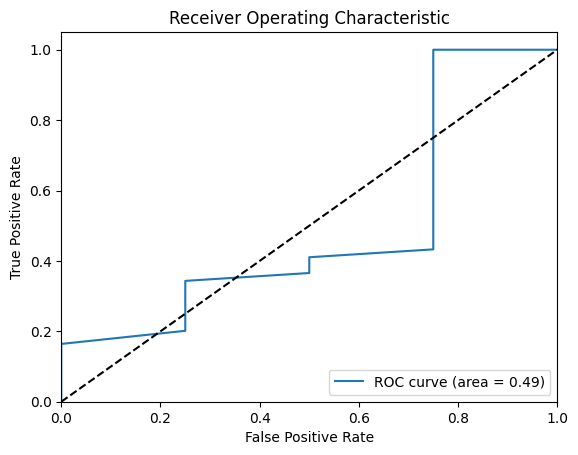

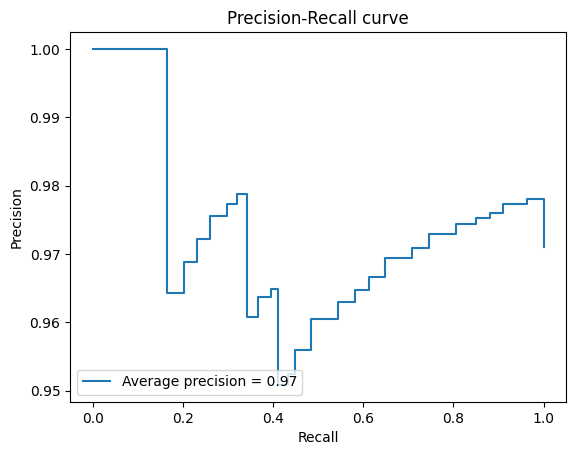

Accuracy: 0.028985507246376812


/var/folders/s2/__5bgsnj1_q86m6cbx0wbr7r0000gn/T/ipykernel_19059/598482173.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Accuracy'], y=[accuracy], palette='viridis')


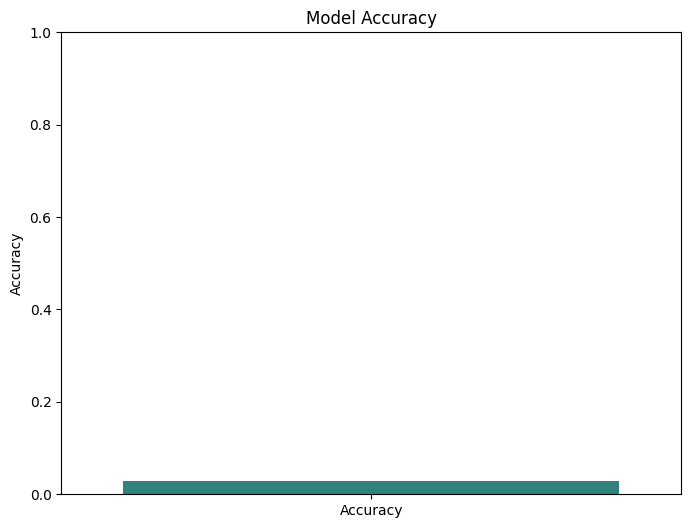

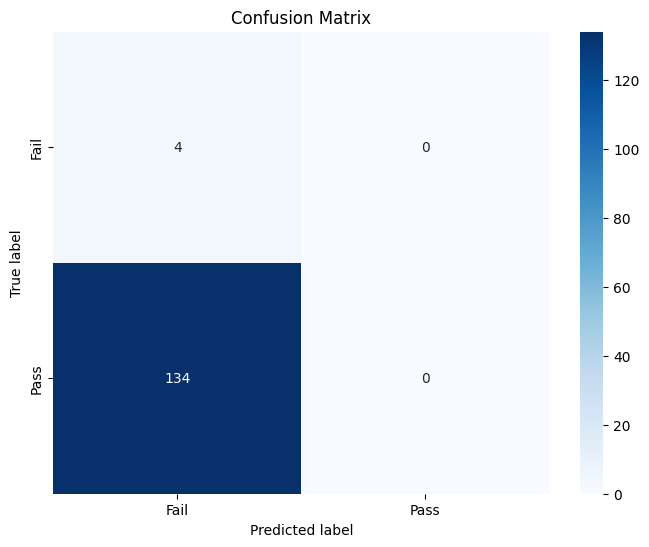

In [22]:

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate ROC AUC

# do using the loaded_model and not clf
y_pred_proba = loaded_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# Calcualte precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)
plt.figure()
plt.step(recall, precision, where='post', label='Average precision = {:.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')
plt.show()


# Calculate accuracy and plot it
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
plt.figure(figsize=(8, 6))
sns.barplot(x=['Accuracy'], y=[accuracy], palette='viridis')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()

# Calculate Confusion Matrix and plot it
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()



### Evaluation Metrics

